In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 데이터 전처리 과정의 추가

단순한 ANN 모델을 바탕으로 데이터의 전/후 처리 과정을 추가한 예제입니다.
Scikit-learn 패키지의 기능들을 자주 사용하게 될 겁니다.

앞서 Sequential API를 통해 DNN 모델을 먼저 만듭니다.

In [0]:
import pandas as pd
import tensorflow as tf
from tensorflow import keras

path = '/content/drive/My Drive/dnn_tutorial/'
#   set LABEL first
output_cols = ['vel']
#   set traffic column
input_cols = ['vel_t05', 'vel_t10', 'vel_t15', 'vel_t20',
               'vel_t25', 'vel_t30', 'vel_t35',  'vel_t40']

model = keras.Sequential()
model.add(keras.layers.Dense(30, input_shape = (len(input_cols),),activation='relu'))
model.add(keras.layers.Dense(30, activation='relu'))
model.add(keras.layers.Dense(30, activation='relu'))
model.add(keras.layers.Dense(30, activation='relu'))
model.add(keras.layers.Dense(1, activation=None))

model.compile(optimizer=tf.keras.optimizers.Adam(0.001), loss='mse', metrics=['mape'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 30)                270       
_________________________________________________________________
dense_6 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_7 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_8 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 31        
Total params: 3,091
Trainable params: 3,091
Non-trainable params: 0
_________________________________________________________________


원본 속도 데이터를 읽어옵니다. 

In [0]:
traffic_data = pd.read_csv(path+ 'traffic_data_org.csv', index_col = 0)

traffic_data.head(5)

이 데이터를 training data와 test data 로 분리하겠습니다.
이때 Scikit-learn 패키지의 train_test_split 을 사용합니다


In [0]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(traffic_data, test_size = 1024)

In [0]:
vel_upper_limit = train_data['vel'].quantile(q=0.98)
train_data = train_data[train_data['vel']<=vel_upper_limit].copy()
train_data.shape

(100434, 11)

train_data 의 일부가 제거된 것을 확인할 수 있습니다.

다음으로는 속도값을 minmaxscaler 를 사용하여 [0.0,1.0] 사이의 값으로 scaling 하겠습니다.

사실 예제 데이터는 모두 같은 위치의 속도이므로 scaling의 의미가 크지 않지만
modality 가 다른 데이터들을 다루는 경우 이러한 scaling이 DNN의 성능에 영향을 미칩니다.

먼저 minmaxscaler를 fitting 하겠습니다.


In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler()
scaler.fit(train_data['vel'].values.reshape(-1,1))


MinMaxScaler(copy=True, feature_range=(0, 1))

scaler에 저장된 최대/최소값은 다음과 같습니다.


In [0]:
print(scaler.data_min_, scaler.data_max_)

[6.9999995] [108.27]


다음으로 데이터프레임의 속도값을 모두 scaling 하는 함수 normalize_numeric 을 작성하여 호출합니다.
함수에서 예측할 속도값의 scaling 전 값을  'backup_vel' 로 저장합니다.


In [0]:
def normalize_numeric(dataframe, input_col_list, output_col_list):
    return_df = dataframe.copy()
    for col in input_col_list:
        return_df.loc[:, col] = pd.DataFrame(
            scaler.transform(return_df[col].values.reshape(-1, 1)),
            columns=[col], index=return_df.index)
    for col in output_col_list:
        col_backup = 'backup_'+col
        return_df[col_backup] = return_df[col].copy()
    for col in output_col_list:
        return_df.loc[:, col] = pd.DataFrame(
            scaler.transform(return_df[col].values.reshape(-1, 1)),
            columns=[col], index=return_df.index)
    return return_df

train_data = normalize_numeric(train_data, input_cols, output_cols)
test_data = normalize_numeric(test_data, input_cols, output_cols)


값이 제대로 변경되었는지 확인해 봅니다.


In [0]:
train_data.head(5)

,vel,date,time,vel_t05,vel_t10,vel_t15,vel_t20,vel_t25,vel_t30,vel_t35,vel_t40,backup_vel
8227487,0.944900,20150405,1335,0.931767,0.949047,0.947961,0.923768,0.928409,0.965044,0.977091,0.941246,102.69
8253996,0.844969,20150708,2150,0.857608,0.865607,0.868372,0.824134,0.839340,0.878345,0.849610,0.862941,92.57
8211317,0.864027,20150208,710,0.872420,0.879629,0.836181,0.837662,0.882887,0.849215,0.897205,0.869063,94.50
8206744,0.895922,20150123,830,0.878740,0.875383,0.864027,0.876370,0.876568,0.832823,0.867680,0.847141,97.73
8298230,0.824035,20151212,1210,0.809025,0.808729,0.823245,0.767552,0.802014,0.791251,0.790461,0.798065,90.45


In [0]:
test_data.head()

Scaling이 원하는 대로 된 듯 하니 학습과 예측을 진행해봅니다.


In [0]:
X_train = train_data[input_cols].values
Y_train = train_data[output_cols].values

model.fit(X_train, Y_train, batch_size=1024, epochs= 10)


Epoch 1/10
99/99 [==============================] - 0s 3ms/step - loss: 0.0353 - mape: 8380.0010
Epoch 2/10
99/99 [==============================] - 0s 3ms/step - loss: 0.0015 - mape: 5315.0068
Epoch 3/10
99/99 [==============================] - 0s 3ms/step - loss: 0.0014 - mape: 5038.8550
Epoch 4/10
99/99 [==============================] - 0s 3ms/step - loss: 0.0014 - mape: 4848.2529
Epoch 5/10
99/99 [==============================] - 0s 3ms/step - loss: 0.0014 - mape: 4844.3672
Epoch 6/10
99/99 [==============================] - 0s 3ms/step - loss: 0.0014 - mape: 4618.4951
Epoch 7/10
99/99 [==============================] - 0s 3ms/step - loss: 0.0014 - mape: 4566.9780
Epoch 8/10
99/99 [==============================] - 0s 3ms/step - loss: 0.0014 - mape: 4296.1450
Epoch 9/10
99/99 [==============================] - 0s 3ms/step - loss: 0.0014 - mape: 4518.4009
Epoch 10/10
99/99 [==============================] - 0s 3ms/step - loss: 0.0014 - mape: 4518.8467


이전 예제와 비교해봤을때 mape 값이 너무 큰 것 같습니다.

예측 결과를 scaling 전으로 변환하여 퍼센트 에러를 비교해보겠습니다.


In [0]:
train_predict= model.predict(X_train)
train_predict =pd.DataFrame(scaler.inverse_transform(train_predict)
, index= train_data.index, columns=['prediction'])
percentage_error = (train_predict['prediction'] - train_data['backup_vel']).abs()/ train_data['backup_vel']*100
print(percentage_error)

8227487    1.257930
8253996    1.078293
8211317    0.222568
8206744    2.746259
8298230    2.035765
             ...   
8258027    1.052734
8274747    2.966221
8221549    3.214484
8290007    1.200424
8234856    3.007335
Length: 100434, dtype: float64


에러의 평균을 계산하여 MAPE를 확인해봅니다.


In [0]:
percentage_error.mean()

2.975918246936467

원래 값으로 변환하여 비교해보니 MAPE가 크게 감소한 것을 볼 수 있습니다.
이렇게 값을 scaling 하여 예측하는 경우 MAPE를 비교하기 보다는 MSE 등을 통해 비교한 값이 좀더 정확한 비교가 될 것입니다.


이전과 마찬가지로 test1_data, test2_data 에 대한 작업도 진행해보겠습니다.


In [0]:
test1_data = pd.read_csv(path+'traffic_data_test1.csv', index_col = 0)
test1_data = normalize_numeric(test1_data, input_cols, output_cols)

X_test1 = test1_data[input_cols].values
Y_test1 = test1_data[output_cols].values

model.evaluate(X_test1, Y_test1)

32/32 [==============================] - 0s 970us/step - loss: 0.0012 - mape: 3.5741


[0.0011575438547879457, 3.574131727218628]

이전과 마찬가지로 test2_data 의 경우 그래프를 그려보겠습니다.

inverse_transform을 적용하지 않고 그려보겠습니다.

9/9 [==============================] - 0s 1ms/step - loss: 0.0049 - mape: 10.4955


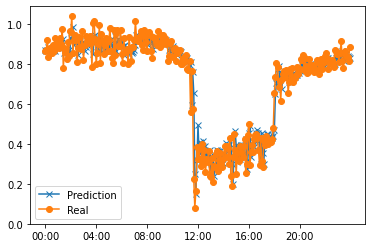

In [0]:
test2_data = pd.read_csv(path+'traffic_data_test2.csv', index_col = 0)
test2_data = normalize_numeric(test2_data, input_cols, output_cols)
test2_data['date'] = pd.to_datetime(test2_data['date'], format='%Y%m%d')
test2_data['time'] = test2_data['time'].map(
                        lambda x: pd.Timedelta(hours=x // 100, minutes=x % 100))
test2_data['datetime'] = test2_data['date'] + test2_data['time']

X_test2= test2_data[input_cols].values
Y_test2 =  test2_data[output_cols].values
model.evaluate(X_test2, Y_test2)
prediction = model.predict(X_test2)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)

im = ax.plot(prediction,'-x',Y_test2, '-o')
ax.set_ylim(bottom=0)
xtick_list = [x for x in range(
        0, len(Y_test2), len(Y_test2) // 6)]
ax.set_xticks(xtick_list)
ax.set_xticklabels([test2_data['datetime'][x].strftime('%H:%M') for x in xtick_list])
ax.legend(['Prediction', 'Real'])


inverse_transform으로 원래 값으로 돌린 후 그래프를 그려보겠습니다.

9/9 [==============================] - 0s 1ms/step - loss: 0.0046 - mape: 10.0244


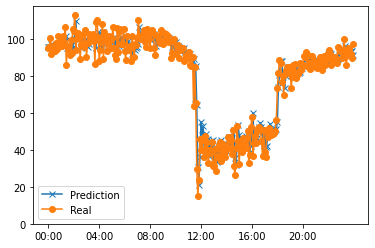

In [0]:
test2_data = pd.read_csv(path+'traffic_data_test2.csv', index_col = 0)
test2_data = normalize_numeric(test2_data, input_cols, output_cols)
test2_data['date'] = pd.to_datetime(test2_data['date'], format='%Y%m%d')
test2_data['time'] = test2_data['time'].map(
                        lambda x: pd.Timedelta(hours=x // 100, minutes=x % 100))
test2_data['datetime'] = test2_data['date'] + test2_data['time']

X_test2= test2_data[input_cols].values
Y_test2 =  test2_data[output_cols].values
model.evaluate(X_test2, Y_test2)
prediction = model.predict(X_test2)

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)

im = ax.plot(scaler.inverse_transform(prediction),'-x',test2_data['backup_vel'], '-o')
ax.set_ylim(bottom=0)
xtick_list = [x for x in range(
        0, len(Y_test2), len(Y_test2) // 6)]
ax.set_xticks(xtick_list)
ax.set_xticklabels([test2_data['datetime'][x].strftime('%H:%M') for x in xtick_list])
ax.legend(['Prediction', 'Real'])